In [1]:
#meta 11/16/2020 Moa - review submission 4 
#based on myFastaiTabularData.ipynb notebook

#mychanges
#refer to my-kaggle-moa-0-eda.ipynb
#handle categorical features: ordinal only
#see if makes any difference

#score didn't approve, was 0.01983(84), here 0.01996
#next: remove coder related to `cp_time` as ordinal

In [2]:
#from fastai.tabular.data import *
from fastai.tabular import *

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/test_features.csv


## 0. Load Data

In [4]:
#$was data_path = "/kaggle/input/lish-moa/"
path = Path('../input/lish-moa')
path.ls()

[PosixPath('../input/lish-moa/sample_submission.csv'),
 PosixPath('../input/lish-moa/train_drug.csv'),
 PosixPath('../input/lish-moa/train_targets_scored.csv'),
 PosixPath('../input/lish-moa/train_targets_nonscored.csv'),
 PosixPath('../input/lish-moa/train_features.csv'),
 PosixPath('../input/lish-moa/test_features.csv')]

In [5]:
train_drugs = pd.read_csv(path/'train_drug.csv')
train_features = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('/kaggle/input/lish-moa/train_targets_nonscored.csv')
test_features = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')
sub = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')

In [6]:
print('Dataset sizes:  \ntrain drugs', train_drugs.shape)
print('train features', train_features.shape)
print('train targets', train_targets_scored.shape)
print('test features', test_features.shape)

display(train_features.head(3))
display(train_targets_scored.head(3))

Dataset sizes:  
train drugs (23814, 2)
train features (23814, 876)
train targets (23814, 207)
test features (3982, 876)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931


,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
train_drugs.describe()

,sig_id,drug_id
count,23814,23814
unique,23814,3289
top,id_3049581f6,cacb2b860
freq,1,1866


In [8]:
##save before changing?
#train_features_original = train_features.copy()

## 1. Data Prep
- Categorical features: cp_type,cp_time,cp_dose
- Combine features and targets 

todo: explore drugs and features  
todo: remove control records from training

In [9]:
#handle categorical features: ordinal only
cp_time = np.sort(train_features['cp_time'].unique()) #numpy.ndarray [24,48,72]

train_features['cp_time'] = train_features['cp_time'].astype('category')
train_features['cp_time'].cat.set_categories(cp_time, ordered=True, inplace=True)
print("ordinal: ", train_features['cp_time'].unique())

test_features['cp_time'] = test_features['cp_time'].astype('category')
test_features['cp_time'].cat.set_categories(cp_time, ordered=True, inplace=True)
print("ordinal: ", test_features['cp_time'].unique())

ordinal:  [24, 72, 48]
Categories (3, int64): [24 < 48 < 72]
ordinal:  [24, 72, 48]
Categories (3, int64): [24 < 48 < 72]


In [10]:
train_features.shape, train_targets_scored.shape #$verify match

((23814, 876), (23814, 207))

In [11]:
#preview results - appended targets
train_features.iloc[1:5,-5:-1]

,c-95,c-96,c-97,c-98
1,0.4899,0.1522,0.1241,0.6077
2,-0.3174,-0.6417,-0.2187,-1.4080
3,-1.2880,-1.6210,-0.8784,-0.3876
4,-0.3031,0.1094,0.2885,-0.3786


In [12]:
##don't train on control records
#EDA finding all drugs cacb2b860 being ctl_vehicle

#train_features = train_features[train_features['cp_type'] != 'ctl_vehicle'].copy()
#train_features.shape

## 2. Model Prep
##### Using TabularPandas and TabularProc

In [13]:
print(train_features.shape)

cat_names = ['cp_type','cp_time','cp_dose']
cont_columns = [i for i in train_features.columns if i not in ['cp_type','cp_time','cp_dose','sig_id']]
dep_var = [i for i in train_targets_scored.columns if i !='sig_id']
train_features[dep_var] = train_targets_scored[dep_var]

print(train_features.shape)

(23814, 876)
(23814, 1082)


In [14]:
procs = [FillMissing,Categorify,Normalize]

In [15]:
dep_var[:10]

['5-alpha_reductase_inhibitor',
 '11-beta-hsd1_inhibitor',
 'acat_inhibitor',
 'acetylcholine_receptor_agonist',
 'acetylcholine_receptor_antagonist',
 'acetylcholinesterase_inhibitor',
 'adenosine_receptor_agonist',
 'adenosine_receptor_antagonist',
 'adenylyl_cyclase_activator',
 'adrenergic_receptor_agonist']

In [16]:
data = (TabularList.from_df(train_features, procs=procs, cont_names=cont_columns, cat_names=cat_names)
        .split_by_rand_pct(valid_pct=0.10,seed=42)
        .label_from_df(cols=dep_var)
        .add_test(TabularList.from_df(test_features, cat_names=cat_names, cont_names=cont_columns, procs=procs))
        .databunch())

In [17]:
learn = tabular_learner(data,layers=[300,200])

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 6.31E-02


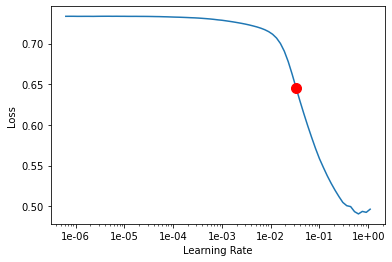

In [18]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [19]:
learn.fit_one_cycle(5, 3.31E-02)

epoch,train_loss,valid_loss,time
0,0.019955,0.018537,00:14
1,0.017272,0.016918,00:15
2,0.015991,0.016017,00:15
3,0.014700,0.015352,00:15
4,0.013828,0.015145,00:15


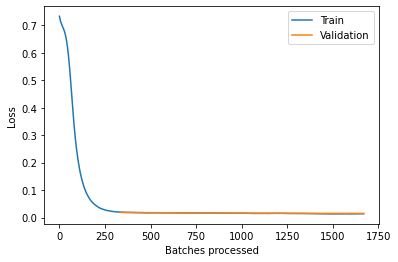

In [20]:
learn.recorder.plot_losses()

In [21]:
learn.unfreeze()
learn.fit_one_cycle(5,slice(1e-04),wd=0.2)

epoch,train_loss,valid_loss,time
0,0.013202,0.015160,00:15
1,0.013083,0.015130,00:16
2,0.013358,0.015123,00:15
3,0.013062,0.015112,00:15
4,0.013100,0.015146,00:15


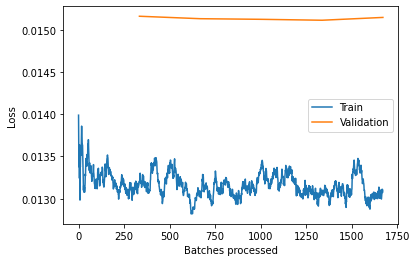

In [22]:
learn.recorder.plot_losses()

In [23]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5),wd=0.25)

epoch,train_loss,valid_loss,time
0,0.013204,0.015123,00:15
1,0.013368,0.015129,00:15
2,0.012946,0.015127,00:15
3,0.012872,0.015120,00:15
4,0.013214,0.015125,00:15


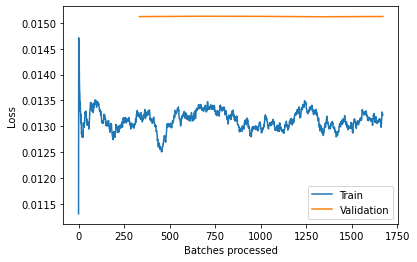

In [24]:
learn.recorder.plot_losses()

In [25]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6),wd=0.4)

epoch,train_loss,valid_loss,time
0,0.013253,0.015107,00:14
1,0.012941,0.015114,00:15
2,0.013147,0.015122,00:15
3,0.013132,0.015118,00:16
4,0.013036,0.015105,00:14


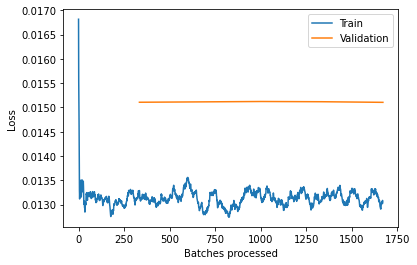

In [26]:
learn.recorder.plot_losses()

## 3, Predict

In [27]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [28]:
submission = pd.DataFrame({'sig_id':sub['sig_id']})
submission[dep_var] = pd.DataFrame(preds.detach().numpy())

In [29]:
submission.loc[submission['sig_id'].isin(test_features.loc[test_features['cp_type'] =='ctl_vehicle', 'sig_id']), train_targets_scored.columns[1:]] = 0

In [30]:
submission.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000276,0.000457,0.001858,0.017430,0.020373,0.003276,0.002429,0.003246,0.000003,...,0.001464,0.000186,0.005833,0.001594,0.000203,0.000175,0.000296,0.001813,0.000492,0.000865
1,id_001897cda,0.000058,0.000198,0.000848,0.001462,0.000678,0.000688,0.001681,0.017147,0.015014,...,0.000192,0.000157,0.000920,0.000052,0.014471,0.000250,0.004347,0.000389,0.005102,0.001622
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.000284,0.000112,0.002613,0.007461,0.015330,0.002008,0.001582,0.013465,0.000008,...,0.000098,0.001226,0.000926,0.001530,0.017408,0.000024,0.003081,0.002510,0.000992,0.004354
4,id_0027f1083,0.000735,0.000662,0.001150,0.018866,0.023041,0.004652,0.002934,0.001213,0.000008,...,0.000471,0.000084,0.004470,0.000745,0.000234,0.000247,0.000528,0.001771,0.000004,0.000573


In [31]:
submission.to_csv('submission.csv',index=False)